## Практическая работа №6
##### Сиразетдинов Рустем (Вариант - 20)

Предсказание стоимости медецинской страховки

Данные: https://www.kaggle.com/mirichoi0218/insurance

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Load data
ins = pd.read_csv('C:\\Users\\averu\\Documents\\git_local\\programming-practice\\IDA-practice-5\\insurance.csv')
print("There are {:,} observations and {} columns in the data set.".format(ins.shape[0], ins.shape[1]))
print("There are {} missing values in the data.".format(ins.isna().sum().sum()))
ins['sex'] = ins['sex'].str.capitalize()
ins['smoker'] = ins['smoker'].apply(lambda x: 'Smoker' if x=='yes' else 'Non-Smoker')
ins['region'] = ins['region'].str.capitalize()

There are 1,338 observations and 7 columns in the data set.
There are 0 missing values in the data.


In [18]:
init_notebook_mode(connected=True)
px.defaults.template = "plotly_white"
plot_df=ins.copy()
fig = px.box(plot_df, x="region", y="charges", color="region", 
             notched=True, points="outliers", height=600,
             title="",
             color_discrete_sequence=['#B14B51', '#D0A99C', '#5D8370', '#6C839B'])
fig.update_traces(marker=dict(size=9, opacity=0.5, line=dict(width=1,color="#F7F7F7")), showlegend=False)
fig.update_layout(font_color="#303030", xaxis_title='Region', yaxis_title='Claim Amount, $',
                  yaxis=dict(showgrid=True, gridwidth=1, gridcolor='#EAEAEA', zerolinecolor='#EAEAEA'))
fig.show()

Для каждого региона графики показывают, что страховые сборы положительно искажены с несколькими большими отклонениями. Страховые сборы более изменчивы в Юго-Восточном регионе, который содержит самую высокую претензию в наборе данных - более 63 000 долларов США, а также самую низкую претензию - 1121 доллар США. Северо-Восточный регион имеет самую высокую среднюю стоимость в целом, хотя, поскольку отметки в графиках накладываются друг на друга, средние суммы претензий, вероятно, существенно не отличаются.

In [19]:
fig=px.histogram(ins, x='charges', color='smoker', opacity=0.7, barmode='overlay',
                 histnorm='probability density', marginal='box', 
                 title="",
                 color_discrete_sequence=['#B14B51','#B7A294']) 
fig.update_layout(font_color="#303030", xaxis_title='Claim Amount, $',
                  yaxis=dict(title='Probability Density', gridcolor='#EAEAEA', zerolinecolor='#EAEAEA'),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""))
fig.update_xaxes(showgrid=False, zerolinecolor='#EAEAEA')
fig.show()

Средняя сумма претензий некурящих составляет около 7300 долларов, что значительно ниже, чем средняя сумма претензий курильщиков, составляющая более 34 000 долларов. Распределение расходов на страхование между группами также заметно отличается. Для некурящих распределение смещено вправо, в то время как суммы претензий для курильщиков имеют большую вариабельность с более широким разбросом в таблице и бимодальным распределением с пиками около 20 000 и 40 000 долларов.

In [20]:
plot_df = ins.copy()
plot_df["Age_Group"]=['18 to 29 years' if i<30 else '30 to 44 years' if (i>=30)&(i<45) else 
                      '45 to 59 years' if (i>=45)&(i<60) else '60 and over' for i in ins['age']]
plot_df = plot_df.groupby(['Age_Group','smoker'])['charges'].mean()
plot_df = plot_df.rename('charges').reset_index().sort_values('smoker', ascending=True)
fig = px.bar(plot_df, x='Age_Group', y='charges', color='smoker', height=500, text='charges', 
             opacity=0.75, barmode='group', color_discrete_sequence=['#B7A294','#B14B51'],
             title="")
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside', 
                  marker_line=dict(width=1, color='#303030'))
fig.update_layout(font_color="#303030",bargroupgap=0.05, bargap=0.3, 
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""),
                  xaxis=dict(title='Age',showgrid=False), 
                  yaxis=dict(title='Claim Amount, $', showgrid=False,zerolinecolor='#DBDBDB',
                             showline=True, linecolor='#DBDBDB', linewidth=2))
fig.show()

В каждой возрастной группе страховые взносы у курильщиков в среднем значительно выше, чем у некурящих. Мы также видим более высокие суммы претензий по мере увеличения возраста, причем самые дорогие претензии относятся к возрастной группе 60 лет и старше.

In [21]:
fig = px.scatter(ins, x='bmi', y='charges', color='smoker', size='charges',
                 title="",
                 color_discrete_sequence=['#B14B51','#B7A294'],height=600)
fig.update_layout(legend=dict(title='',orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                  font_color="#303030", xaxis=dict(title='Body Mass Index (BMI)',showgrid=False), 
                  yaxis=dict(title='Claim Amount, $',showgrid=False, zerolinecolor='#E5E5EA',
                             showline=True, linecolor='#E5E5EA', linewidth=2))
fig.show()

В дополнение к возрасту, суммы претензий положительно коррелируют с индексом массы тела. Среди курильщиков страховые взносы, как правило, увеличиваются с увеличением ИМТ.

In [22]:
plot_df = ins.groupby(['region','sex','smoker'])['charges'].mean()
plot_df = plot_df.rename('charges').reset_index()
fig = px.bar(plot_df, x='region', y='charges', color='sex', height=800,
             title="",
             color_discrete_map={'Female': '#BFC5DA','Male': '#5D6A92'}, 
             facet_row='smoker', text='charges', opacity=0.85, barmode='group')
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside', 
                  marker_line=dict(width=1, color='#303030'))
fig.layout.yaxis2.update(matches=None)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(title="Region", row=1)
fig.update_yaxes(title="Claim Amount, $",  gridcolor='#E3E3E3', zeroline=True, zerolinewidth=2, 
                 showgrid=False, zerolinecolor='#E5E5EA',
                 showline=True, linecolor='#E5E5EA', linewidth=2)
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white",
                  bargroupgap=0.05, bargap=0.2,
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""))
fig.show()

У некурящих, как правило, страховые претензии в среднем меньше, чем у курильщиков, - чуть менее 10 000 долларов в каждом регионе, в то время как претензии курильщиков варьируются в среднем от 28 000 до более 36 000 долларов. График также показывает, что у некурящих женщин средние расходы несколько выше, чем у мужчин, в то время как среди курильщиков у мужчин средние расходы несколько выше, чем у женщин.

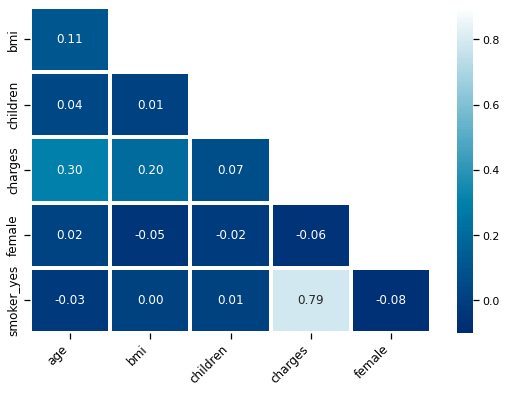

In [23]:
ins['female'] = ins['sex'].apply(lambda x: 1 if x=='Female' else 0)
ins['smoker_yes'] = ins['smoker'].apply(lambda x: 1 if x=='Smoker' else 0)
ins.drop(['sex', 'smoker'], axis=1, inplace=True)

sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(9,6))   
corr=ins.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr=corr.iloc[1:,:-1].copy()
ax=sns.heatmap(corr, mask=mask, vmin=-.1, vmax=.9, center=0, annot=True, fmt='.2f', 
               cmap='ocean', linewidths=4, annot_kws={"fontsize":12})
ax.set_title('', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
fig.show()

Корреляционная матрица показывает, что курильщики имеют сильную положительную связь со страховыми взносами на уровне 0,79, но в целом переменные в наборе данных не слишком сильно коррелируют друг с другом.

In [24]:
actuals=[]
preds=[]
rmses=[]
r2_scores=[]
adj_r2_scores=[]
feat_importance=pd.DataFrame()
regions = ins.region.unique()
s = StandardScaler()
col = ["#B14B51", '#D0A99C', '#5D8370','#6C839B']

for i in regions:
    
    # Filter data by region
    ins_df = ins[ins.region==i]
    X=ins_df.drop(['charges', 'region'], axis=1)
    y=ins_df.charges
    
    
    # Add polynomial features
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names(X.columns))
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=1)
    X_train = pd.DataFrame(X_train, columns = X_pf.columns)
    X_test = pd.DataFrame(X_test, columns = X_pf.columns)
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    print("\nRegion: {}\n".format(i))
    print("Train Shape:{} {}  Test Shape:{} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    
    # Scale features
    X_train = pd.DataFrame(data=s.fit_transform(X_train), columns=X_pf.columns)
    X_test = pd.DataFrame(data=s.transform(X_test), columns=X_pf.columns)
    
    # Tuning 
    grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5],
            'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],
            'subsample': [0.5, 0.8, 1],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_depth': [int(x) for x in np.linspace(2, 10, num = 5)],
            'max_features': [None, 'sqrt']}
    xgb=GradientBoostingRegressor(random_state=21)
    xgb_cv=RandomizedSearchCV(estimator=xgb, param_distributions=grid, scoring='neg_mean_squared_error', 
                              n_iter=100, cv=3, random_state=21, n_jobs=-1)
    xgb_cv.fit(X_train, y_train)
    y_pred=xgb_cv.predict(X_test)
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmse=np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2=r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    # Save feature importance
    feat_importance["Importance_"+str(i)]=xgb_cv.best_estimator_.feature_importances_
    
    print("Test Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))
    if i != 'Northeast':
        print("__________________________")

# Plot results
for i in range(0,4):
    actuals[i].loc[:,'index']=regions[i]
actual = pd.concat([actuals[i] for i in range(4)], axis = 0)
pred = pd.concat([preds[i] for i in range(4)], axis = 0)
df = pd.concat([actual, pred], axis=1).reset_index(drop=True)

fig = px.scatter(df, x="actuals", y="preds", color="index", trendline="lowess", height=700,
                 title="Реальные vs Предсказанные результаты стоимости соответсвтующих регионам,<br>Gradient Boosting",
                 color_discrete_sequence=col, opacity=0.7, facet_col='index', facet_col_wrap=2)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[0]*100,rmses[0]),
                   x=51e3,y=15e3, row=2,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[1]*100,rmses[1]),
                   x=51e3,y=15e3, row=2,col=2, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[2]*100,rmses[2]),
                   x=51e3,y=15e3, row=1,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[3]*100,rmses[3]),
                   x=51e3,y=15e3, row=1,col=2, showarrow=False)

fig.update_traces(hovertemplate="Actual Cost: %{x:$,.2f}<br>Predicted Cost: %{y:$,.2f}",
                  marker=dict(size=10,line=dict(width=1,color="#F7F7F7")),
                  selector=dict(mode="markers"), showlegend=False)
fig.update_xaxes(title="Actual Cost, $", row=1)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#EAEAEA',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_yaxes(title="Predicted Cost, $", col=1)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E3E3E3',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white")
fig.show()


Region: Southwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 4,117.69
R-Squared = 87.64%, Adjusted R-Squared = 82.03%
__________________________

Region: Southeast

Train Shape:(291, 20) (291,)  Test Shape:(73, 20) (73,)
Test Error (RMSE) = 3,212.02
R-Squared = 95.48%, Adjusted R-Squared = 93.74%
__________________________

Region: Northwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 4,559.91
R-Squared = 86.63%, Adjusted R-Squared = 80.55%
__________________________

Region: Northeast

Train Shape:(259, 20) (259,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 5,275.79
R-Squared = 73.68%, Adjusted R-Squared = 61.71%


In [25]:
models=["Linear Regression", "KNN", "SVM", "Gradient Boosting"]
mod_res=pd.DataFrame(columns=["Average RMSE", "Avg. Adjusted R2"], index=models)

mod_res.iloc[3,0]=pd.Series(rmses).mean()
mod_res.iloc[3,1]=pd.Series(adj_r2_scores).mean()
mod_res["Average RMSE"]=mod_res["Average RMSE"].map('{:,.2f}'.format)
mod_res["Avg. Adjusted R2"]=mod_res["Avg. Adjusted R2"].mul(100).map('{:.2f}%'.format)
display(mod_res.sort_values("Average RMSE"))

,Average RMSE,Avg. Adjusted R2
Gradient Boosting,"4,291.35",79.51%
Linear Regression,nan,nan%
KNN,nan,nan%
SVM,nan,nan%


In [27]:
col=sns.color_palette("magma", 20).as_hex()[::-1]
feat_importance.set_index(X_train.columns, inplace=True)
ft=pd.DataFrame({"Средняя значимость":feat_importance.mean(axis=1)})
plot_df=ft.nlargest(20, columns="Средняя значимость").sort_values(by="Средняя значимость",ascending=False)
fig = px.bar(plot_df, x="Средняя значимость", y=plot_df.index, text="Средняя значимость", height=700,
             color=plot_df.index,width=700,opacity=.8,color_discrete_sequence=col)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside',
                  marker_line=dict(width=1, color='#3F3B3A'), showlegend=False, 
                  hovertemplate='Значимость = <b>%{x:.2}</b>')
fig.update_layout(title_text='Значимость факторов при оценке стоимости медиуинской страховки', 
                  coloraxis_showscale=False, yaxis_title="", font_color="#303030", yaxis_linecolor="#D8D8D8", 
                  xaxis=dict(title="Средняя значимость", showgrid=True, showline=True, 
                             linecolor="#9A9A9A", gridcolor="#F5F5F5"))